# JijZept デモンストレーション

このnotebookでは、実際にJijZeptを用いて組合せ最適化問題を解いてみます。
扱う題材として、「**会議室割り当て問題**」「**巡回セールスマン問題**」「**ナップザック問題**」を扱います。

本チュートリアルを進めるにあたり、**自身のマシンにPython環境を構築する必要はありません**。

現在開いているjupyterの環境に全て用意されています。

## 会議室割り当て問題 (グラフ彩色問題)


![](https://raw.githubusercontent.com/Jij-Inc/JijHandsOnMaterials/handson-environment/ja/images/part1_jijzept_layer.png)

$N$個の会議が予定されていますが、会議室は$K (K < N)$個しかありません。このとき、各会議を被らないようにうまく会議室に割り当てるにはどうすればよいでしょうか。

例えば以下のような会議スケジュールがあるとします。

|  Meeting ID  |  Start  | End |
| ---- | ---- | --- |
|  0  |  09:00  | 11:00 |
|  1  |  10:00  | 11:30 |
|  2  |  10:30  | 12:00 |
|  3  |  14:00  | 15:00 |
|  4  |  12:00  | 13:00 |
|  5  |  11:00  | 11:45 |
|  6  |  13:00  | 14:00 |
|  7  |  11:45  | 13:00 |
|  8  |  10:45  | 13:00 |
|  9  |  10:00  | 11:00 |
| 10  |  11:30  | 14:00 |
| 11  |  11:30  | 13:00 |
| 12  |  11:30  | 13:00 |
| 13  |  14:00  | 15:00 |
| 14  |  13:30  | 15:00 |
| 15  |  13:00  | 15:00 |


上記のように会議が16個予定されていますが、会議室が4つしかない場合を考えます。

では、さっそく各会議がかぶらないようにするための会議室割り当てを最適化問題として定式化しましょう。

まず、数理最適化を行う場合は出力したい計画（ここでは会議をどの部屋に割り当てるか）を変数として表現します。今回の割り当てを以下の0-1変数で定義します。

$$x_{v, i} \in \{0, 1\}, v: \text{会議}, i: \text{部屋}$$

ここで$x_{v, i}$は会議$v$を部屋$i$に割り当てるとき1そうでないとき0とする変数です。

この定義により今回は$x$の各値を求めればよいことになります。このように計画に対応するこれから決める変数を「決定変数」と呼びます。

次に各会議のスケジュールを反映するデータを用意します。
会議 $v$を会議$w$の時間がかぶっているとき1でそうでないときに0となるデータ $a_{v, w}$を用意します。

この$a$と$x$を用いて今回最小化しなくてはいけない数式（目的関数）は以下となります。

$$\sum_{v} \sum_{w} \sum_{i=1}^{K} a_{v,w} x_{v, i} x_{w, i}$$

ここで$K$は部屋の数です。この数式は例えば
- $a_{v, w} = 1$のとき => 両方1 ($x_{v, i} = 1, x_{w, i} = 1$) だと $a_{v,w} x_{v, i} x_{w, i} = 1$
- $a_{v, w} = 1$のとき => 片方0 ($x_{v, i} = 0, x_{w, i} = 1$) だと $a_{v,w} x_{v, i} x_{w, i} = 0$
- $a_{v, w} = 0$のとき => 両方1でも ($x_{v, i} = 0, x_{w, i} = 1$) だと $a_{v,w} x_{v, i} x_{w, i} = 0$

となります。つまり会議の時間がかぶっている($a_{v,w} = 1$)とき、会議$v$と会議$w$を同じ部屋$i$に割り当ててしまう($x_{v, i} = 1, x_{w, i} = 1$)と先程の数式の値が大きくなってしまいます。目的関数が0であれば会議室にかぶりがなく各会議を割り当てることができます。

しかし、これだけではどの部屋にも会議を割り当てないというのが答えとして出てくる可能性があるのでそれを防ぐ制約条件を設定します。

それが

$$\sum_{i=1}^{K}x_{v, i} = 1, ~\forall v$$

という制約条件です。各会議に対して部屋の割り当ては一つのみということを意味します。

まとめると解くべき最適化問題は以下です。

$$
\min_x \sum_{v} \sum_{w} \sum_{i=1}^{K} a_{v,w} x_{v, i} x_{w, i}
$$

$$\sum_{i=1}^K x_{v, i} = 1,~\forall v$$
$$x_{v, i} \in \{0, 1\}$$


実はこの会議室割り当て問題は、各会議を頂点として、時間がかぶっている会議同士に線を引くとより最適化問題として見やすくなります。

![](https://raw.githubusercontent.com/Jij-Inc/JijHandsOnMaterials/main/ja/images/meeting_graph.png)

会議の時間割とグラフは

- 各会議 <-> グラフのノード
- 会議間に時間の被りがある <-> ノード間にエッジが存在

という対応関係を持ちます。

このようにグラフの問題に変換すると、

- 会議を`会議に重複がない`ように`会議室を割り当てる` 問題

という問題を

- `繋がっているノードは別の色`になるように`ノードに色を塗る`問題 (グラフ彩色問題)

に変換することができます。

### JijModelingを使った数理モデリング

In [1]:
import jijmodeling as jm
a = jm.Placeholder("a", dim=2)
N = a.shape[0].set_latex("N") # meetingの数
K = jm.Placeholder("K")            # 部屋の数

x = jm.Binary("x", shape=(N, K)) # バイナリ変数 最適化する変数

v, w = jm.Element("v", (0, N)), jm.Element("w", (0, N))
i = jm.Element("i", (0, K))


# QUBOを作る
problem = jm.Problem("graph coloring")

# Cost term
problem += jm.Sum([v, w, i], a[v, w]*x[v, i] * x[w, i])

# Constraint term
problem += jm.Constraint("one-color", jm.Sum(i, x[v, i]) == 1, forall=v)
problem

### インスタンスデータの作成
JijModelingにて定義した変数である
* $a_{v, w}$ (会議$v$、会議$w$のスケジュールが重複した際のペナルティ値)
* $K$ (会議室の数)

の値を設定します。

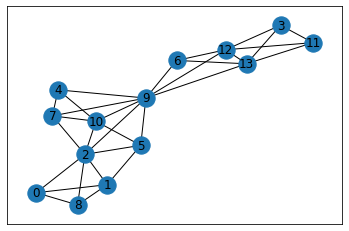

In [2]:
from typing import Tuple
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

timetable = [
    (9, 11),    (10, 11.5),
    (10.5, 12), (14, 15),
    (12, 13), (11, 11.7),
    (13, 14),
    (11.7, 13), (10, 11),
    (11.5, 14), (11.5, 13),
    (14, 15),
    (13.5, 15), (13, 15),
]

edge_list = []
adjacency_matrix = np.zeros((len(timetable), len(timetable)))

def has_edge(meeting1: Tuple[float, float], meeting2: Tuple[float, float]):
    if not meeting1[1] <= meeting2[0]:
        if not meeting2[1] <= meeting1[0]:
            return True
    return False

for u, meeting_u in enumerate(timetable[:-1]):
    for _v, meeting_v in enumerate(timetable[u+1:]):
        v = u + _v + 1
        if has_edge(meeting_u, meeting_v):
            edge_list.append((u, v))
            adjacency_matrix[u, v] = 1
            adjacency_matrix[v, u] = 1

graph = nx.Graph()
graph.add_edges_from(edge_list)
nx.draw_networkx(graph)
plt.show()

In [3]:
instance_data = {
    "a": adjacency_matrix,
    "K": 4
}

### JijZeptを使ってみる

JijZeptを用いて上でモデリングした問題を解いてみます。

以前のハンズオンでは、イジングマシンが扱える形式に変換する際に、制約条件を罰金項として
$$
\sum_{v} \sum_{w} \sum_{i=1}^{K} a_{v,w} x_{v, i} x_{w, i}
+A\sum_v \left(\sum_{i=1}^K x_{v, i} -1\right)^2\\
x_{v, i} \in \{0, 1\}
$$

![](https://raw.githubusercontent.com/Jij-Inc/JijHandsOnMaterials/handson-environment/ja/images/graph_coloring_qubo.png)

と記述してから、$A$の値を経験と勘で頑張って調整する必要がありましたが、
`search=True`のオプションを設定するだけで、**最適なパラメータを自動で探索**できます。

まず、同じディレクトリに次のような設定で `config.toml`を作成し、保存します。


```toml
[default]
url = "https://api.jijzept.com"
token = "<Your API key from JijZept portal site>"
```

続いて、作成した `config.toml`をJijZeptで使用します。

In [4]:
import jijzept as jz
import jijmodeling as jm
sampler = jz.JijSASampler(config="config.toml")
# 等式で記述された制約を必ず満たすように探索するには、次のように`jz.JijSwapMovingSampler`を使うことができます
#sampler = jz.JijSwapMovingSampler()
# 今後、様々な量子デバイス、イジング計算機に対応予定となります。
result = sampler.sample_model(problem, instance_data, search=True, num_reads=10)
decoded = problem.decode(result, instance_data)

uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is ae4c1bfce751443290c7dfd74b75848c.


パラメータを探索する過程を図示すると、制約条件の破れ (オレンジ線)を小さくしつつ、コスト関数 (青線)も小さくするようにJijZeptが動いているのがわかります。

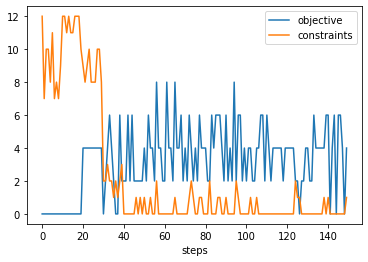

In [5]:
# パラメータサーチにより得られた解の目的関数と制約条件の破れ一覧を表示
plt.plot(list(range(0, len(decoded.objectives))), decoded.objectives, label='objective')
plt.plot(list(range(0, len(decoded.constraint_violations))), [elem['one-color'] for elem in decoded.constraint_violations], label='constraints')
plt.xlabel("steps")
plt.legend()
plt.show()

In [6]:
# 実行可能解 (制約を満たしている解) のみを取得します。
feasibles = decoded.feasibles()

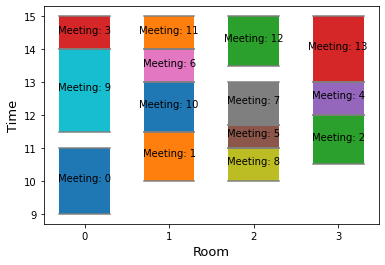

In [7]:
def plot_timetable(timetable, solution):
    rooms = solution
    assignment = {i: r for i, r in enumerate(rooms)}
    for meeting, room in assignment.items():
        plt.plot([room - 0.3, room + 0.3], [timetable[meeting][0]]*2, color='gray')
        plt.plot([room - 0.3, room + 0.3], [timetable[meeting][1]]*2, color='gray')
        plt.fill_between([room - 0.3, room + 0.3], [timetable[meeting][0]]*2, [timetable[meeting][1]]*2)
        plt.text(room, np.mean(timetable[meeting]), 'Meeting: '+ str(meeting), ha='center', fontsize=10)
    plt.xticks(list(range(min(rooms), max(rooms)+1)))
    plt.xlabel('Room', fontsize=13)
    plt.ylabel('Time', fontsize=13)

x_value = feasibles.solution[feasibles.objective.argmin()]['x']
solution = np.where(x_value == 1)[1]
plot_timetable(timetable, solution)
plt.show()

`result.info`にて、最良の結果を出力した際のパラメータを表示できます。

各パラメータはそれぞれ、
$$
\min_x \sum_{v} \sum_{w} \sum_{i=1}^{K} a_{v,w} x_{v, i} x_{w, i}
+\sum_v A^{\mathrm{linear}}_v\left(\sum_{i=1}^K x_{v, i} -1\right)+\sum_v A^{\mathrm{quad}}_v\left(\sum_{i=1}^K x_{v, i} -1\right)^2\\
x_{v, i} \in \{0, 1\}
$$
の$A^{\mathrm{linear}}_v$、$A^{\mathrm{quad}}_v$に対応します。

In [8]:
print(result.info['best_parameters'])

{'parameters': {'linear': {'one-color': [[[0], -2.5], [[1], -1.3055555555555554], [[2], -1.3055555555555554], [[3], -2.5], [[4], 0.05555555555555536], [[5], -1.25], [[6], -1.25], [[7], 0.05555555555555536], [[8], 0.05555555555555536], [[9], -1.3055555555555554], [[10], 0.05555555555555536], [[11], -1.3055555555555554], [[12], 2.201388888888889], [[13], -0.8958333333333335]]}, 'quad': {'one-color': [[[0], 5.0], [[1], 8.805555555555555], [[2], 8.805555555555555], [[3], 5.0], [[4], 7.555555555555555], [[5], 5.0], [[6], 5.0], [[7], 7.555555555555555], [[8], 7.555555555555555], [[9], 8.805555555555555], [[10], 7.555555555555555], [[11], 8.805555555555555], [[12], 4.701388888888889], [[13], 8.506944444444445]]}}, 'constraint_violations': {'one-color': 0.0}, 'objective': 2.0}


## 巡回セールスマン問題

複数の都市をなるべく最短経路で巡るにはどうすればよいか？

![](https://raw.githubusercontent.com/Jij-Inc/JijHandsOnMaterials/handson-environment/ja/images/tsp1.png)
![](https://raw.githubusercontent.com/Jij-Inc/JijHandsOnMaterials/handson-environment/ja/images/tsp2.png)

### 定式化

$$
\begin{aligned}
\min_x & \sum_{i,j}d_{i,j}x_{i,t} x_{j,(t+1)\mod n}\\
\mathrm{s.t.} &\sum_t x_{i,t}=1, \forall i\\
&\sum_i x_{i,t} = 1,~\forall t\\
&x_{i,t} \in \{0, 1\}
\end{aligned}
$$

### インスタンスの作成

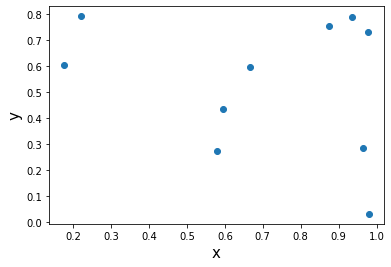

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# ランダムに都市を配置して距離行列を計算
def tsp_distance(n: int):
    x = np.random.uniform(0, 1, n)
    y = np.random.uniform(0, 1, n)
    XX, YY = np.meshgrid(x, y)
    distance = np.sqrt((XX - XX.T)**2 + (YY - YY.T)**2)
    return distance, (x, y)

# n-都市 平面TSP
n = 10

distance, (x_pos, y_pos) = tsp_distance(n=n)

plt.plot(x_pos, y_pos, 'o')
plt.xlabel("x", fontsize=15)
plt.ylabel("y", fontsize=15)
plt.show()

### JijModelingによる実装

In [10]:
import jijmodeling as jm

n = jm.Placeholder("n")
d = jm.Placeholder("d", shape=(n, n))

x = jm.Binary("x", shape=(n, n))

i = jm.Element("i", (0, n))
j = jm.Element("j", (0, n))
t = jm.Element("t", (0, n))

# problem object の作成
problem = jm.Problem("tsp")

# 目的関数の追加
problem += jm.Sum([i, j, t], d[i, j]*x[i, t]*x[j, (t+1) % n])
# 等価な書き方
# problem += jm.Sum(i, jm.Sum(j, jm.Sum(t, d[i, j]*x[i, t]*x[j, (t+1) % n])))

# 2つの制約条件の追加
problem += jm.Constraint("one-city", jm.Sum(t, x[i, t]) == 1, forall=i)
problem += jm.Constraint("one-time", jm.Sum(i, x[i, t]) == 1, forall=t)
problem

In [11]:
instance_data = {
    "d": distance,
    "n": len(distance)
}

In [12]:
import jijzept as jz
import jijmodeling as jm
sampler = jz.JijSASampler(config="config.toml")
result = sampler.sample_model(problem, instance_data, search=True, num_sweeps=10000, num_search=50)
decoded = problem.decode(result, instance_data)

uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is c9b1efa8918442e29545b07e57e498f3.
It takes a lot of time to get the solution...
You can also access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("c9b1efa8918442e29545b07e57e498f3")
running...


In [13]:
decoded

DecodedSamples(feasibles = 45[/50], objective = 0.0, energy = -43.03396287296334)

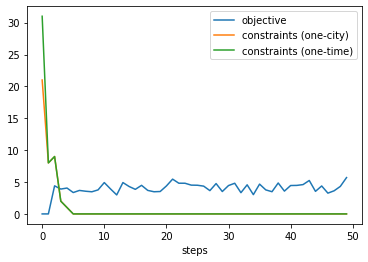

In [14]:
# パラメータサーチにより得られた解の目的関数と制約条件の破れ一覧を表示
plt.plot(list(range(0, len(decoded.objectives))), decoded.objectives, label='objective')
plt.plot(list(range(0, len(decoded.constraint_violations))), [elem['one-city'] for elem in decoded.constraint_violations], label='constraints (one-city)')
plt.plot(list(range(0, len(decoded.constraint_violations))), [elem['one-time'] for elem in decoded.constraint_violations], label='constraints (one-time)')
plt.xlabel("steps")
plt.legend()
plt.show()

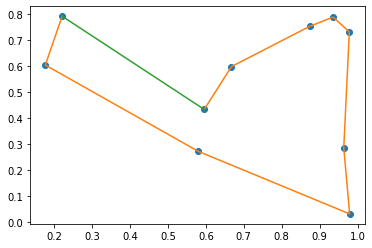

In [15]:
import numpy as np

feasibles = decoded.feasibles()
argmin_e = np.argmin(feasibles.objective)
tour = np.where(feasibles[argmin_e].solution['x'].T == 1)[1]
plt.plot(x_pos, y_pos, "o")
plt.plot(x_pos[tour], y_pos[tour], "-")
plt.plot(x_pos[[tour[-1], tour[0]]], y_pos[[tour[-1], tour[0]]], "-")

## ナップザック問題 (不等式の制約条件)

容量の制約を守ったまま、なるべく優先度が高い荷物を多く詰めるにはどうすればよいか？

![](https://raw.githubusercontent.com/Jij-Inc/JijHandsOnMaterials/handson-environment/ja/images/knapsack.png)

### 定式化

In [16]:
w = jm.Placeholder("weights", dim=1)
v = jm.Placeholder("values", dim=1)
n = jm.Placeholder("num_items").set_latex("n")
c = jm.Placeholder("capacity")
x = jm.Binary("x", shape=(n, ))
# i: itemの添字
i = jm.Element("i", n)

problem = jm.Problem("knapsack")

# objective function
obj = jm.Sum(i, v[i] * x[i])
problem += -1 * obj

# Constraint: knapsack 制約
const = jm.Constraint("knapsack_constraint", jm.Sum(i, w[i] * x[i])  <= c)
problem += const
problem

uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 6a9e8ae5d46d457480a9646cf8bc4841.
running...


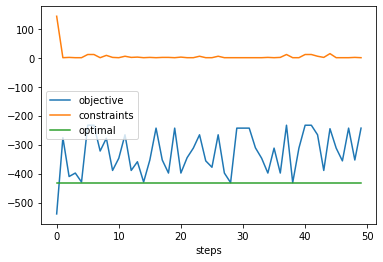

[1. 1. 1. 1. 1. 1. 1. 0. 1. 0.]


In [17]:
instance_data = {
    "weights": [55.0, 10.0, 47.0, 5.0, 4.0, 50.0, 8.0, 61.0, 85.0, 87.0],
    "values": [95.0, 4.0, 60.0, 32.0, 23.0, 72.0, 80.0, 62.0, 65.0, 46.0],
    "num_items": 10,
    "capacity": 269}

import jijzept as jz
import jijmodeling as jm
sampler = jz.JijSASampler(config="config.toml")
result = sampler.sample_model(problem, instance_data, search=True, num_search=50)
decoded = problem.decode(result, instance_data)

# パラメータサーチにより得られた解の目的関数と制約条件の破れ一覧を表示
plt.plot(list(range(0, len(decoded.objectives))), decoded.objectives, label='objective')
plt.plot(list(range(0, len(decoded.constraint_violations))), [elem['knapsack_constraint'] for elem in decoded.constraint_violations], label='constraints')
plt.plot(list(range(0, len(decoded.constraint_violations))), [-431]*len(decoded.constraint_violations), label='optimal')

plt.xlabel("steps")
plt.legend()
plt.show()

# 得られた答えを表示
feasibles = decoded.feasibles()
argmin_e = np.argmin(feasibles.objective)
print(feasibles[argmin_e].solution['x'])